In [3]:
#Modified version of the following script from nilearn: 
#https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html
from nilearn import datasets
from tqdm.notebook import tqdm

abide_dataset = datasets.fetch_abide_pcp(n_subjects=200)

In [11]:
abide_dataset.keys()

dict_keys(['description', 'phenotypic', 'func_preproc'])

In [20]:
from nilearn import input_data

msdl_data = datasets.fetch_atlas_msdl()
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

/home/fleetwood/miniconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [21]:
pooled_subjects = []
groups = []
for func_file, dx in tqdm(zip(abide_dataset['func_preproc'], abide_dataset['phenotypic']['DX_GROUP'])):
    time_series = masker.transform(func_file)
    pooled_subjects.append(time_series)
    groups.append(dx)

print(f'Dataset has {len(pooled_subjects)} subjects')

0it [00:00, ?it/s]

Dataset has 200 subjects


In [38]:
for elem in pooled_subjects:
    print(elem.shape)

(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(196, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(206, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78, 39)
(78,

In [43]:
print(len(groups))

200


In [44]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from nilearn.connectome import ConnectivityMeasure
import rust_dtw
import numpy as np

kinds = ['dtw', 'correlation', 'partial correlation', 'tangent']
# kinds = ['correlation']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    print('PROCESSING: ', kind)
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        if kind == 'dtw':
#             Having to do it this way because there are different time series configurations in the provided
#             data. Otherwise rust_dtw.dtw_connectomes would be easier
            connectomes = []
            for subj in pooled_subjects[train]:
                connectomes.append(
                    rust_dtw.dtw_connectome(
                    connectome=subj,
                    window=100, 
                    distance_mode="euclidean")
                )
            test_connectomes = []
            for subj in pooled_subjects[test]:
                test_connectomes.append(
                    rust_dtw.dtw_connectome(
                    connectome=subj,
                    window=100,  
                    distance_mode="euclidean")
                )
        else:
            connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
            connectomes = connectivity.fit_transform(pooled_subjects[train])
            test_connectomes = connectivity.transform(pooled_subjects[test])
            
        classifier = LinearSVC(max_iter=10000).fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(test_connectomes)
        
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

PROCESSING:  dtw


/home/fleetwood/miniconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:983: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fleetwood/miniconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:983: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


PROCESSING:  correlation
PROCESSING:  partial correlation
PROCESSING:  tangent


[(0.6933333333333332, 'dtw'), (0.6400000000000001, 'correlation'), (0.6133333333333334, 'partial correlation'), (0.6933333333333332, 'tangent')]


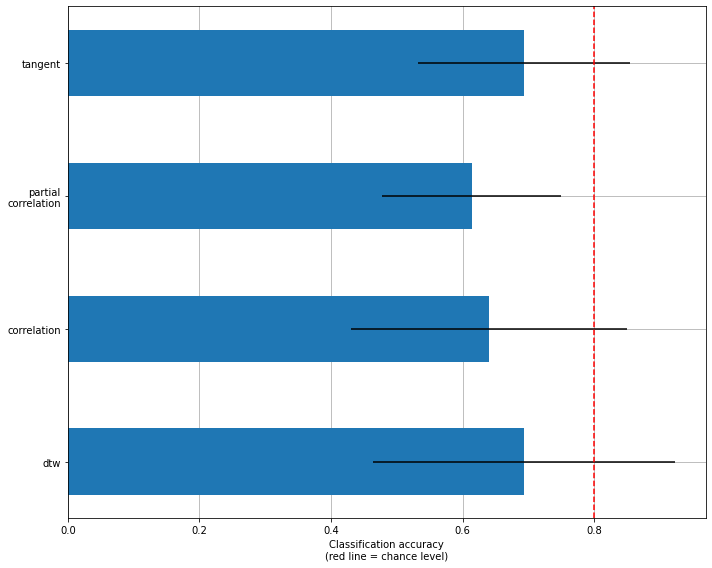

In [45]:
import matplotlib.pyplot as plt
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print(list(zip(mean_scores, kinds) ))
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(10, 8))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()